
# Homework 6 - Polynomial Regression & Generalized Additive Models (GAMs)

**Estimated completion time: 2 hours (including write-up)**

This week's coding homework will rely heavily on ISLP Ch 7.8 (page 310). Having the textbook open will be very helpful for understanding the code. We will be using the [**ISLP Wage**](https://islp.readthedocs.io/en/latest/datasets/Wage.html) dataset.

**Goal 1:** Fit a polynomial linear regression model as well as a polynomial logistic regression model to predict Wage from Age. Then, use **cross-validation** to choose the best **polynomial degree (d)**.

**Goal 2:** Fit a GAM to predict Wage from `year`,`age`, and `education`.


# Setup and imports

In [1]:

!pip install -q ISLP pandas numpy matplotlib patsy statsmodels pygam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import statsmodels.api as sm
from patsy import dmatrix, build_design_matrices
from pygam import (s as s_gam ,l as l_gam,f as f_gam,LinearGAM ,LogisticGAM)
from ISLP.transforms import (BSpline ,NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam ,degrees_of_freedom ,plot as plot_gam ,anova as anova_gam)
from ISLP.models import (summarize ,poly ,ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from ISLP import load_data

# Modeling (feature engineering + estimators + CV)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Part 1 - Polynomial Regression

We start by demonstrating how Figure 7.1 can be reproduced. Let's begin
by loading the data.

In [2]:
# Load the Wage dataset
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']
Wage.head()


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


Throughout most of this lab, our response is `Wage['wage']`, which we
have stored as y above. As in Section 3.6.6, we will use the `poly()` function
to create a model matrix that will fit a 4th degree polynomial in `age`.

Read more about the `poly()` function in the textbook section.

In [3]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In the code above, the first line executes the `fit()` method using the dataframe Wage. This recomputes and stores as attributes any parameters needed by `Poly()` on the training data, and these will be used on all subsequent evaluations of the `transform()` method. For example, it is used on the second line, as well as in the plotting function developed below. We now create a grid of values for age at which we want predictions.

In [4]:

age_grid = np.linspace(age.min(),age.max(),100)
age_df = pd.DataFrame({'age': age_grid})


Finally, we wish to plot the data and add the fit from the fourth-degree polynomial. As we will make several similar plots below, we first write a function to create all the ingredients and produce the plot. Our function takes in a model specification (here a basis specified by a transform), as well as a grid of age values. The function produces a fitted curve as well as 95% confidence bands. By using an argument for basis we can produce and plot the results with several different transforms.

In [5]:
def plot_wage_fit(age_df ,basis ,title):
  X = basis.transform(Wage)
  Xnew = basis.transform(age_df)
  M = sm.OLS(y, X).fit()
  preds = M.get_prediction(Xnew)
  bands = preds.conf_int(alpha=0.05)
  fig , ax = subplots(figsize=(8,8))
  ax.scatter(age,y,facecolor='gray',
  alpha=0.5)

  for val , ls in zip([preds.predicted_mean ,bands[:,0],bands[:,1]],['b','r--','r--']):
    ax.plot(age_df.values , val , ls, linewidth=3)
    ax.set_title(title , fontsize =20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
  return ax

## **The following plot should reproduce Figure 7.1 (left) in the ISLP textbook!**

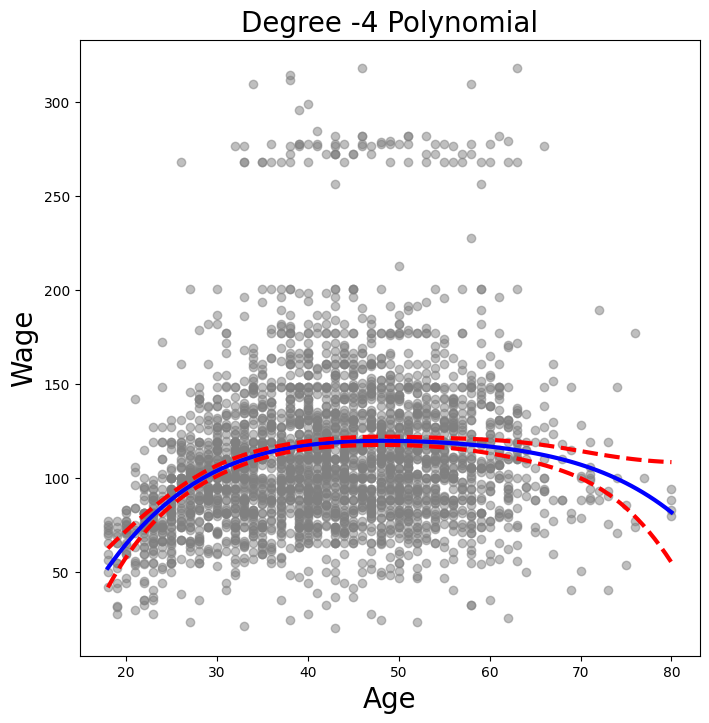

In [6]:
plot_wage_fit(age_df ,poly_age ,'Degree -4 Polynomial');

Next we consider the task of predicting whether an individual earns more than $250k per year. We proceed much as before, except that first we create the appropriate response vector (splitting Wage into "high" and "low" earners), and then apply the `glm()` function using the binomial family in order to fit a polynomial logistic regression model.

In [7]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250,X,family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


## **The following plot should reproduce Figure 7.1 (right) in the ISLP textbook!**

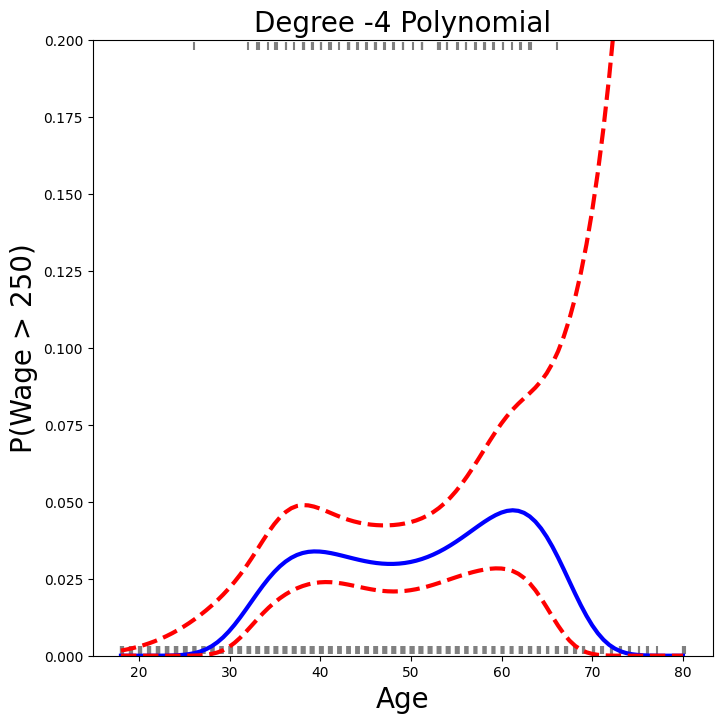

In [8]:
# make predictions
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

fig , ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +0.2 * rng.uniform(size=y.shape[0]),np.where(high_earn , 0.198, 0.002),fc='gray',marker='|')
for val , ls in zip([preds.predicted_mean ,bands[:,0],bands[:,1]],['b','r--','r--']):
  ax.plot(age_df.values , val , ls, linewidth=3)
  ax.set_title('Degree -4 Polynomial', fontsize=20)
  ax.set_xlabel('Age', fontsize=20)
  ax.set_ylim ([0,0.2])
  ax.set_ylabel('P(Wage > 250)', fontsize=20);

# Using cross-validation to determine $d$ for polynomial regression

**In the following sections, we deviate from the textbook, so read carefully:**

1. We create polynomial features of `age` up to degree $d \in \{1,2,3,4,5\}$
2. We then fit a linear regression inside a `Pipeline`.  
3. We assess generalization error with **10-fold cross-validation** and report **mean squared error (MSE)** across folds.



In [9]:
degrees = [1, 2, 3, 4,5] # the degrees of polynomial regression to fit

# 10-fold CV with shuffling (reproducible)
kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

X = Wage['age'].values.reshape(-1, 1)  # reshape age to be 2D
y = Wage['wage'].values

lin_cv_rows = []
for d in degrees:
    pipe = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),  # include_bias=False so intercept handled by LinearRegression
        ('lin', LinearRegression())
    ])
    scores = cross_val_score(pipe, X, y, cv=kfold, scoring='neg_mean_squared_error')  # negative by convention
    mse_mean = -scores.mean()  # convert back to positive MSE
    lin_cv_rows.append((d, mse_mean))

lin_cv_df = pd.DataFrame(lin_cv_rows, columns=['degree', 'cv_mse']).sort_values('degree').reset_index(drop=True)
print("Polynomial regression: Cross-validated MSE by degree:")
display(lin_cv_df.round({'cv_mse': 3})) # round to 3 digits

# Identify the best degree (lowest mean CV MSE)
best_lin_degree = int(lin_cv_df.loc[lin_cv_df['cv_mse'].idxmin(), 'degree'])
print(f"Best linear polynomial degree (found using CV): d = {best_lin_degree}")

# QUESTION 1

Polynomial regression: Cross-validated MSE by degree:


,degree,cv_mse
0,1,1677.504
1,2,1600.903
2,3,1597.003
3,4,1595.880
4,5,1595.980


Best linear polynomial degree (found using CV): d = 4


In [10]:
degrees = [1, 2, 3, 4, 5, 6 ,7,8,9,10,11] # the degrees of polynomial regression to fit

# 10-fold CV with shuffling (reproducible)
kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

X = Wage['age'].values.reshape(-1, 1)  # reshape age to be 2D
y = Wage['wage'].values

lin_cv_rows = []
for d in degrees:
    pipe = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),  # include_bias=False so intercept handled by LinearRegression
        ('lin', LinearRegression())
    ])
    scores = cross_val_score(pipe, X, y, cv=kfold, scoring='neg_mean_squared_error')  # negative by convention
    mse_mean = -scores.mean()  # convert back to positive MSE
    lin_cv_rows.append((d, mse_mean))

lin_cv_df = pd.DataFrame(lin_cv_rows, columns=['degree', 'cv_mse']).sort_values('degree').reset_index(drop=True)
print("Polynomial regression: Cross-validated MSE by degree:")
display(lin_cv_df.round({'cv_mse': 3})) # round to 3 digits

# Identify the best degree (lowest mean CV MSE)
best_lin_degree = int(lin_cv_df.loc[lin_cv_df['cv_mse'].idxmin(), 'degree'])
print(f"Best linear polynomial degree (found using CV): d = {best_lin_degree}")

# QUESTION 1

Polynomial regression: Cross-validated MSE by degree:


,degree,cv_mse
0,1,1677.504
1,2,1600.903
2,3,1597.003
3,4,1595.880
4,5,1595.980
5,6,1595.841
6,7,1594.733
7,8,1594.054
8,9,1596.433
9,10,1603.868


Best linear polynomial degree (found using CV): d = 8


## Plot CV MSE vs degree

* We can plot the mean CV MSE per $d$
* The best degree (lowest mean CV MSE) is highlighted to guide model selection.

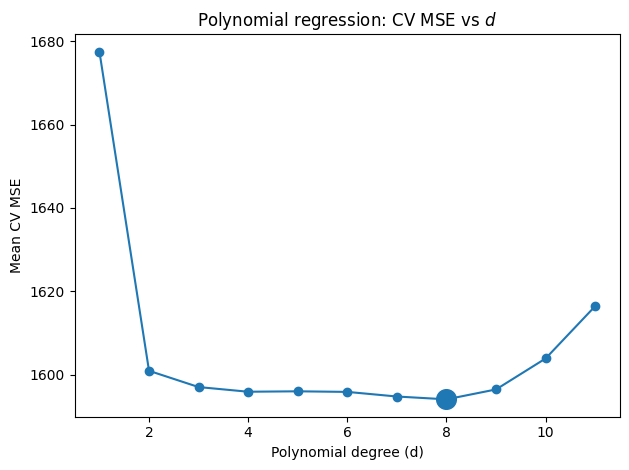

In [11]:
plt.figure()
plt.errorbar(lin_cv_df['degree'], lin_cv_df['cv_mse'], fmt='-o')
best_idx = lin_cv_df['degree'].tolist().index(best_lin_degree)
plt.scatter([lin_cv_df.loc[best_idx, 'degree']], [lin_cv_df.loc[best_idx, 'cv_mse']], s=200)
plt.xlabel('Polynomial degree (d)')
plt.ylabel('Mean CV MSE')
plt.title('Polynomial regression: CV MSE vs $d$')
plt.tight_layout()
plt.show()

# QUESTION 2

##  Refit best polynomial linear model and predict wages

We now **refit** the best polynomial linear model on the **full dataset** to obtain final parameter estimates. We can then compute predicted wages at `age ∈ {30, 50, 70}` and present them in a small table.


In [12]:
# ages you want to predict the wage for
ages = [30, 50, 70];

# Refit best linear model on full data
best_lin_model = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=best_lin_degree, include_bias=False)),
    ('lin', LinearRegression())
])
best_lin_model.fit(X, y)

# Predict at specific ages
ages_to_predict = np.array(ages).reshape(-1, 1)
wage_hat = best_lin_model.predict(ages_to_predict)

lin_pred_df = pd.DataFrame({'age': ages_to_predict.flatten(), 'predicted_wage': wage_hat.round(2)})
print("Predicted wages (best linear model):")
display(lin_pred_df)

# QUESTION 3

Predicted wages (best linear model):


,age,predicted_wage
0,30,102.81
1,50,117.89
2,70,104.18


## Overlay: best linear polynomial curve on the scatter of `wage` vs `age`

* We can now overlay the **best linear model** on top of the scatter.  
* The fitted curve helps visualize the learned trend across ages. We generate a smooth age grid, predict wages, and draw a single curve.

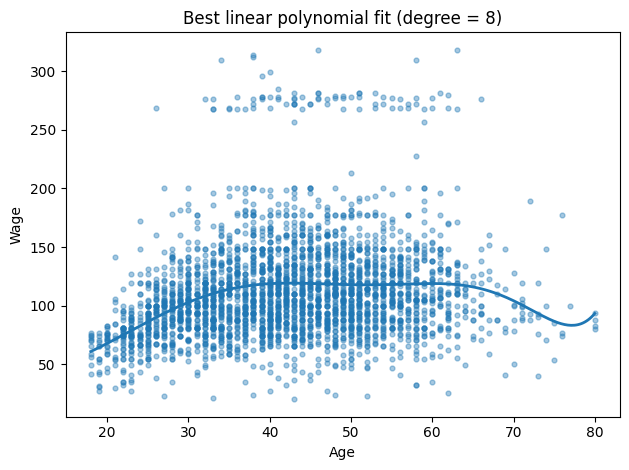

In [13]:
# Build a smooth grid of ages spanning the observed range
age_min, age_max = float(X.min()), float(X.max())
age_grid = np.linspace(age_min, age_max, 300).reshape(-1, 1)

# Predict wages on the grid using the already-fitted best_lin_model
y_grid_hat = best_lin_model.predict(age_grid)

# Plot scatter and overlay the fitted curve
plt.figure()
plt.scatter(X, y, alpha=0.4, s=12)  # base scatter
plt.plot(age_grid.flatten(), y_grid_hat, linewidth=2)              # fitted polynomial curve
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title(f'Best linear polynomial fit (degree = {best_lin_degree})')
plt.tight_layout()
plt.show()

# QUESTION 3

# Using CV to determine the best $d$ for polynomial **logistic** regression

1. We can define a binary outcome $ p(\text{Wage} > T | \text{Age}) > 0.5$ and use a logistic regression model to predict high earners from low earners.
2. We then create polynomial features of `age` up to degree $d \in \{1,2,3,4,5\}$ as before, but now with a logistic regression model
3. We then fit the polynomial logistic regression models inside a `Pipeline`.  
4. We assess classification accuracy with **10-fold cross-validation** and report **classification error** across folds.


In [14]:
# QUESTION 4
# Initial high-earner threshold
T = np.median(y)  # exploring changing this T
# Create binary target
y_bin = (y > T).astype(int)
n = len(y_bin)
pos = int(y_bin.sum())
neg = int(n - pos)

print(f"Class counts -> positives: {pos}, negatives: {neg}")

Class counts -> positives: 1483, negatives: 1517


In [15]:
cv_rows = []
for d in degrees:
    pipe = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('log', LogisticRegression(max_iter=1000))
    ])
    scores = cross_val_score(pipe, X, y_bin, cv=kfold, scoring='accuracy')
    err_mean = 1.0 - scores.mean()   # error = 1 - accuracy
    cv_rows.append((d, err_mean))

cv_df = pd.DataFrame(cv_rows, columns=['degree', 'err_mean']).sort_values('degree').reset_index(drop=True)
print("Cross-validated classification error by degree (logistic):")
display(cv_df.round({'err_mean': 4}))

best_log_degree = int(cv_df.loc[cv_df['err_mean'].idxmin(), 'degree'])
print(f"Best logistic polynomial degree by CV error: d = {best_log_degree}")

# QUESTION 5

Cross-validated classification error by degree (logistic):


,degree,err_mean
0,1,0.4260
1,2,0.4010
2,3,0.3993
3,4,0.4033
4,5,0.4043
5,6,0.4053
6,7,0.4540
7,8,0.4997
8,9,0.4983
9,10,0.4980


Best logistic polynomial degree by CV error: d = 3


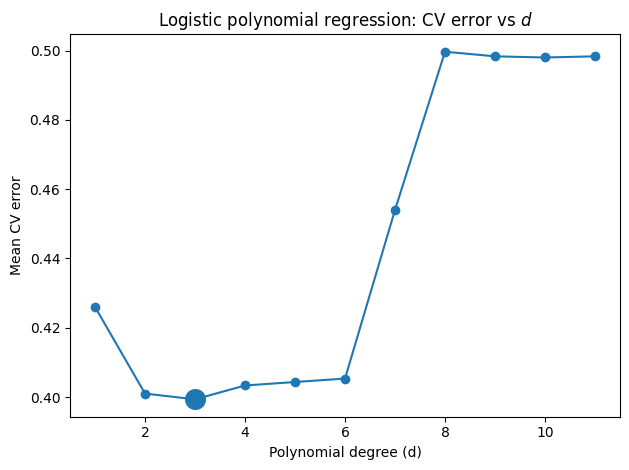

In [16]:
plt.figure()
plt.errorbar(cv_df['degree'], cv_df['err_mean'], fmt='-o')
best_idx = cv_df['degree'].tolist().index(best_log_degree)
plt.scatter([cv_df.loc[best_idx, 'degree']], [cv_df.loc[best_idx, 'err_mean']], s=200)
plt.xlabel('Polynomial degree (d)')
plt.ylabel('Mean CV error')
plt.title('Logistic polynomial regression: CV error vs $d$')
plt.tight_layout()
plt.show()


##  Refit best polynomial logistic model and predict $\Pr(\text{wage}>T)$

We now **refit** the best polynomial logistic model on the **full dataset** to obtain final parameter estimates. We can then compute predicted wages at `age ∈ {30, 50, 70}` and present them in a small table.


In [17]:
best_log_model = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=best_log_degree, include_bias=False)),
    ('log', LogisticRegression(max_iter=1000))
])
best_log_model.fit(X, y_bin)

ages_to_predict = np.array(ages).reshape(-1, 1)
proba_hat = best_log_model.predict_proba(ages_to_predict)[:, 1]

log_pred_df = pd.DataFrame({'age': ages_to_predict.flatten(), 'predicted_probability': np.round(proba_hat, 3)})
print(f"Predicted probabilities P(wage > T | age) with T = {T:.2f}:")
display(log_pred_df)

# QUESTION 6

Predicted probabilities P(wage > T | age) with T = 104.92:


,age,predicted_probability
0,30,0.349
1,50,0.609
2,70,0.387


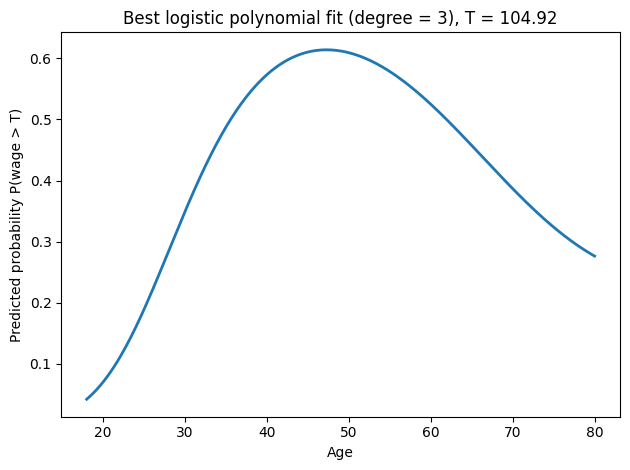

In [18]:
# Smooth age grid for probability curve
age_grid = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

# Predict probabilities with the already-fitted best_log_model
proba_grid = best_log_model.predict_proba(age_grid)[:, 1]

# Plot the probability curve
plt.figure()
plt.plot(age_grid.flatten(), proba_grid, linewidth=2)
plt.xlabel('Age')
plt.ylabel('Predicted probability P(wage > T)')
plt.title(f'Best logistic polynomial fit (degree = {best_log_degree}), T = {T:.2f}')
plt.tight_layout()
plt.show()

## Comparing the linear and logistic polynomial regression models using AIC/BIC

Since scikit-learn models like `LogisticRegression` don't directly compute AIC or BIC, we will refit the best models using `statsmodels` and store the AIC and BIC values before plotting.

In [19]:
ic_rows = []

# Build polynomial design matrix (exclude bias here; we'll add intercept explicitly)
poly = PolynomialFeatures(degree=best_log_degree, include_bias=False)
Z = poly.fit_transform(X)
X_sm = sm.add_constant(Z, has_constant='add')  # add intercept column
# Logistic (Binomial) Logit
log_res = sm.Logit(y_bin, X_sm).fit(disp=False)
ic_rows.append(('logistic', best_log_degree, float(log_res.aic), float(log_res.bic)))

poly = PolynomialFeatures(degree=best_lin_degree, include_bias=False)
Z = poly.fit_transform(X)
X_sm = sm.add_constant(Z, has_constant='add')  # add intercept column
# Linear (Gaussian) OLS
lin_res = sm.OLS(y, X_sm).fit()
ic_rows.append(('linear', best_lin_degree, float(lin_res.aic), float(lin_res.bic)))

ic_df = pd.DataFrame(ic_rows, columns=['model_type', 'degree', 'AIC', 'BIC']).sort_values(['model_type', 'degree']).reset_index(drop=True)
# Pull rows for the best degrees from the information-criteria table built earlier
best_lin_ic = ic_df[(ic_df['model_type'] == 'linear') & (ic_df['degree'] == best_lin_degree)].copy()
best_log_ic = ic_df[(ic_df['model_type'] == 'logistic') & (ic_df['degree'] == best_log_degree)].copy()
print("Information criteria (full-data fits):")
display(ic_df)

Information criteria (full-data fits):


,model_type,degree,AIC,BIC
0,linear,8,30638.409069,30680.453642
1,logistic,3,3889.919599,3913.945069


## Plot AIC and BIC of best linear and logistic polynomial regression models as bar plots

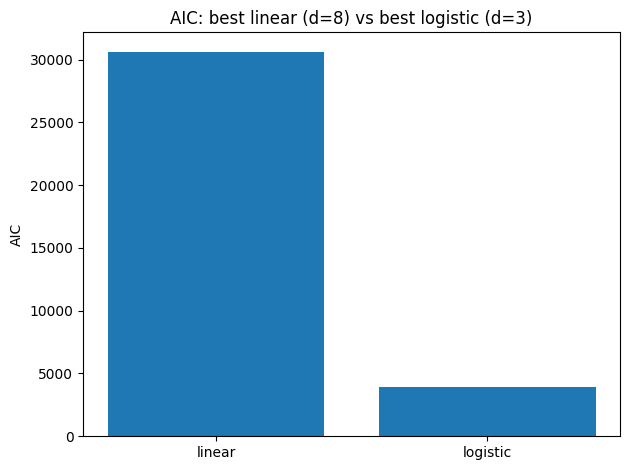

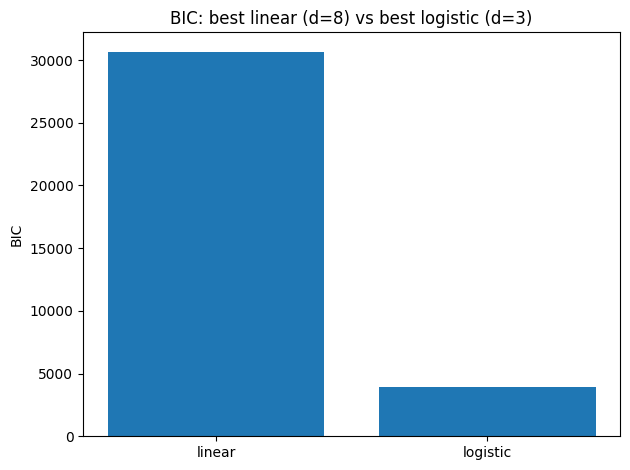

In [20]:

# Bar chart for AIC (best models only)
labels = ['linear', 'logistic']
aic_vals = [float(best_lin_ic['AIC'].iloc[0]), float(best_log_ic['AIC'].iloc[0])]

plt.figure()
x = np.arange(len(labels))
plt.bar(x, aic_vals)
plt.xticks(x, labels)
plt.ylabel('AIC')
plt.title(f'AIC: best linear (d={best_lin_degree}) vs best logistic (d={best_log_degree})')
plt.tight_layout()
plt.show()

# Bar chart for BIC (best models only)
bic_vals = [float(best_lin_ic['BIC'].iloc[0]), float(best_log_ic['BIC'].iloc[0])]

plt.figure()
x = np.arange(len(labels))
plt.bar(x, bic_vals)
plt.xticks(x, labels)
plt.ylabel('BIC')
plt.title(f'BIC: best linear (d={best_lin_degree}) vs best logistic (d={best_log_degree})')
plt.tight_layout()
plt.show()

# QUESTION 7


## Part 2 — Linear GAMs

In this part of the coding exercise, we return back to the textbook exercise as a reference (see page 319, starting with **Additive Models with Several Terms**).

We will be demonstrating how Figure 7.11 can be reproduced.

The strength of GAMs lies in their ability to fit multivariate regression models with more flexibility than linear models. We demonstrate two approaches: the first in a more manual fashion using natural splines and piecewise constant functions, and the second using the `pygam` package and smoothing splines.


* We now fit a GAM by hand to predict wage using natural spline functions
of year and age, treating education as a qualitative predictor, as in (7.16).

* Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the `sm.OLS()` function.

* We will build the model matrix in a more manual fashion here, since we
wish to access the pieces separately when constructing partial dependence
plots.

Specifically, we construct a model matrix with:
- a natural spline basis for `age` (df=4),
- a natural spline basis for `year` (df=5),
- and **all** indicator columns for the categorical `education` (no intercept).

Then fit with `statsmodels.OLS` and manually produce partial dependence plots by
holding other columns at their mean while varying one term's columns.

In [21]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
ns_year.transform(Wage['year']),
pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

We now show how to construct partial dependence plots for each of the terms in our rudimentary GAM. We can do this by hand, given grids for age and year. We simply predict with new X matrices, fixing all but one of the features at a time.

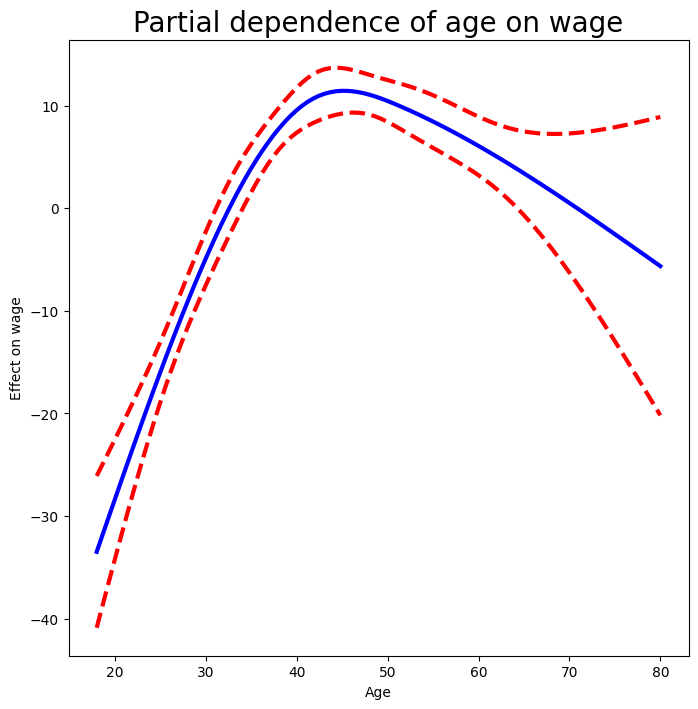

In [22]:
age_grid = np.linspace(age.min(), age.max(), 100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None ,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

fig , ax = subplots(figsize=(8,8))
ax.plot(age_grid , partial_age , 'b', linewidth=3)
ax.plot(age_grid , bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid , bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

# QUESTION 8

Let’s explain in some detail what we did above. The idea is to create a new
prediction matrix, where all but the columns belonging to `age` are constant
(and set to their training-data means). The four columns for `age` are filled
in with the natural spline basis evaluated at the 100 values in `age_grid`.

1. We made a grid of length 100 in `age`, and created a matrix `X_age_bh`
with 100 rows and the same number of columns as`X_bh`.
2. We replaced every row of this matrix with the column means of the
original.
3. We then replace just the first four columns representing `age` with the
natural spline basis computed at the values in `age_grid`.

We also look at the effect of year on wage; the process is the same.

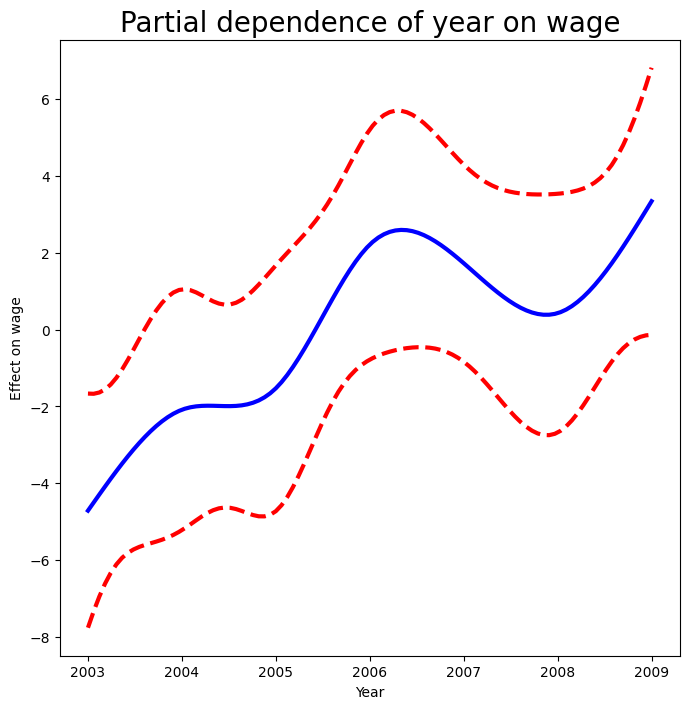

In [23]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),Wage['year'].max(),100)

X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None ,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)

preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha =0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center

fig , ax = subplots(figsize=(8,8))
ax.plot(year_grid , partial_year , 'b', linewidth=3)
ax.plot(year_grid , bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid , bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);
# QUESTION 8

* We can now fit the model (7.16) using smoothing splines rather than natural
splines. All of the terms in (7.16) are fit simultaneously, taking each
other into account to explain the response.

* The `pygam` package only works with matrices, so we must convert the categorical series `education` to its array representation, which can be found with the `cat.codes` attribute of `education`. As year only has 7 unique values, we use only seven basis functions for it.

In [24]:
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2, lam=0))
Xgam = np.column_stack([age , Wage['year'], Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam , y)

* The two `s_gam()` terms result in smoothing spline fits, and use a default
value for $\lambda$ (lam=0.6), which is somewhat arbitrary. For the categorical term `education`, specified using a `f_gam()` term, we specify `lam=0` to avoid any shrinkage.

* We produce the partial dependence plot in `age` to see the effect of these choices.

* The values for the plot are generated by the `pygam package`. We provide
a `plot_gam()` function for partial-dependence plots in `ISLP.pygam`, which makes this job easier than in our last example with natural splines

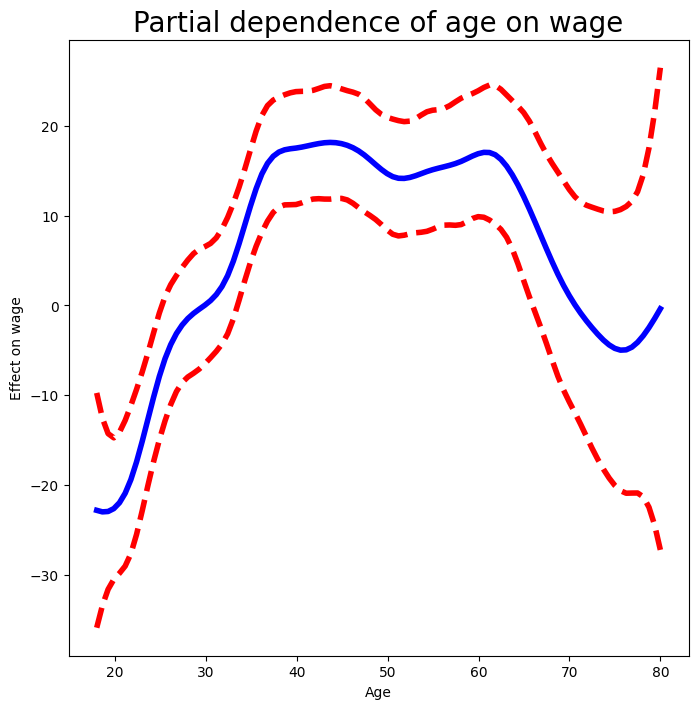

In [25]:
fig , ax = subplots(figsize=(8,8))
plot_gam(gam_full , 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage',fontsize=20);

# QUESTION 8

* We see that the function is somewhat wiggly. It is more natural to specify the degrees of freedom than a value for $\lambda$.

* We refit a GAM using four degrees of freedom each for age and year. Recall that the addition of one below takes into account the intercept of the smoothing spline

Text(0.5, 1.0, 'Partial dependence of year on wage')

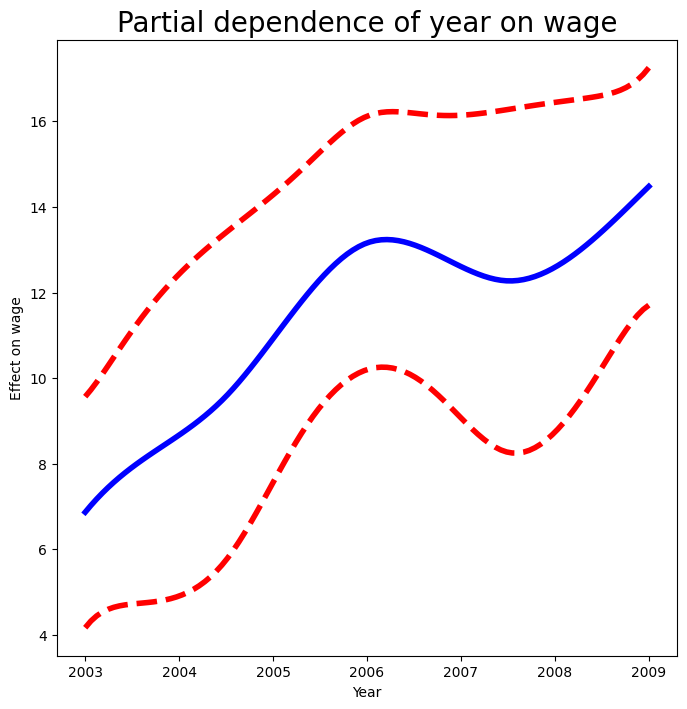

In [26]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam , age_term , df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam , year_term , df=4+1)
gam_full = gam_full.fit(Xgam , y)

# plot
fig , ax = subplots(figsize=(8,8))
plot_gam(gam_full ,
1,
ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

# QUESTION 8

Finally we plot `education`, which is categorical. The partial dependence plot is different, and more suitable for the set of fitted constants for each level of this variable.

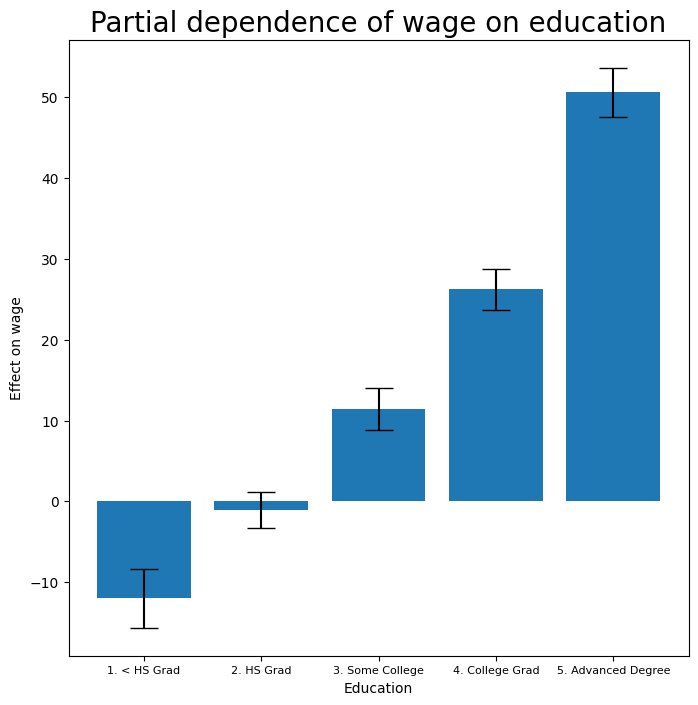

In [27]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full , 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize =20);
ax.set_xticklabels(Wage['education'].cat.categories , fontsize =8);

# QUESTION 8


## Part 3 — Logistic GAMs

We now turn our attention to a Logistic GAM, which can be fit on our `Wage` data by defining a binary target `high_earn` (e.g., wage \> 250).

In order to fit a logistic regression GAM, we use `LogisticGAM()` from `pygam`.




In [28]:
# # QUESTION 9
# T = 250; # threshold of which you define a high earner
# high_earn = (Wage['wage'] > T).astype(int).to_numpy() # define high earners

# Wage['high_earn'] = (Wage['wage'] > T).astype(int)

# # since there are no high earners in the first category of education, the model will have a hard time fitting
# pd.crosstab(Wage['high_earn'], Wage['education'])

# # as a workaround, we can fit a logistic regression GAM excluding all observations falling into this category
# only_hs = Wage['education'] == '1. < HS Grad'
# Wage_ = Wage.loc[~only_hs]
# Xgam_ = np.column_stack([Wage_['age'],
# Wage_['year'],
# Wage_['education'].cat.codes -1]) # subtract 1 from the codes of the category, due to a bug in pygam (relabels the education values)
# high_earn_ = Wage_['high_earn']

# gam_logit_ = LogisticGAM(age_term + year_term + f_gam(2, lam=0))
# gam_logit_.fit(Xgam_ , high_earn_)

In [29]:
# QUESTION 9
T = 100; # threshold of which you define a high earner
high_earn = (Wage['wage'] > T).astype(int).to_numpy() # define high earners

Wage['high_earn'] = (Wage['wage'] > T).astype(int)

# since there are no high earners in the first category of education, the model will have a hard time fitting
pd.crosstab(Wage['high_earn'], Wage['education'])

# as a workaround, we can fit a logistic regression GAM excluding all observations falling into this category
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
Wage_['year'],
Wage_['education'].cat.codes -1]) # subtract 1 from the codes of the category, due to a bug in pygam (relabels the education values)
high_earn_ = Wage_['high_earn']

gam_logit_ = LogisticGAM(age_term + year_term + f_gam(2, lam=0))
gam_logit_.fit(Xgam_ , high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

Now we can look at the partial effect of education, year and age on high earner status now that we've removed those observations:

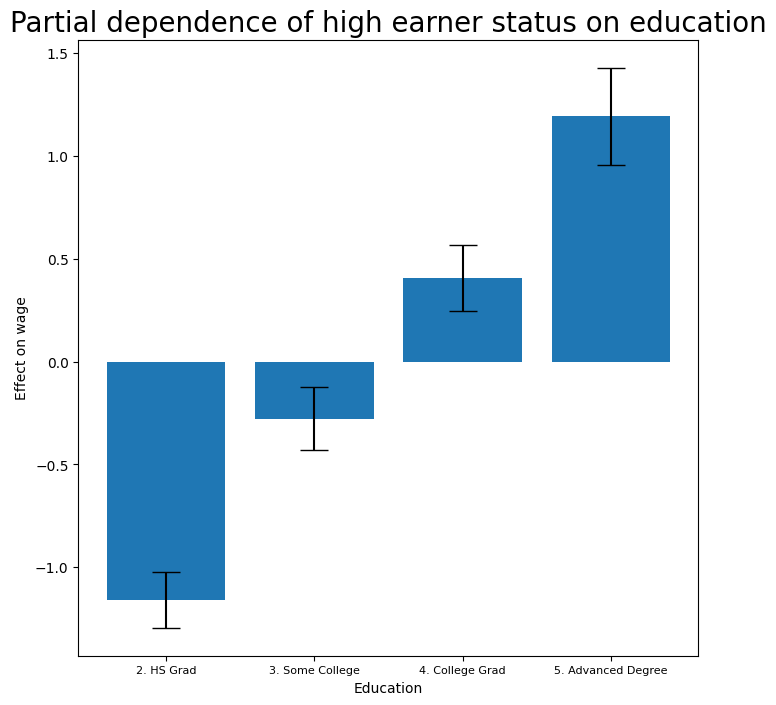

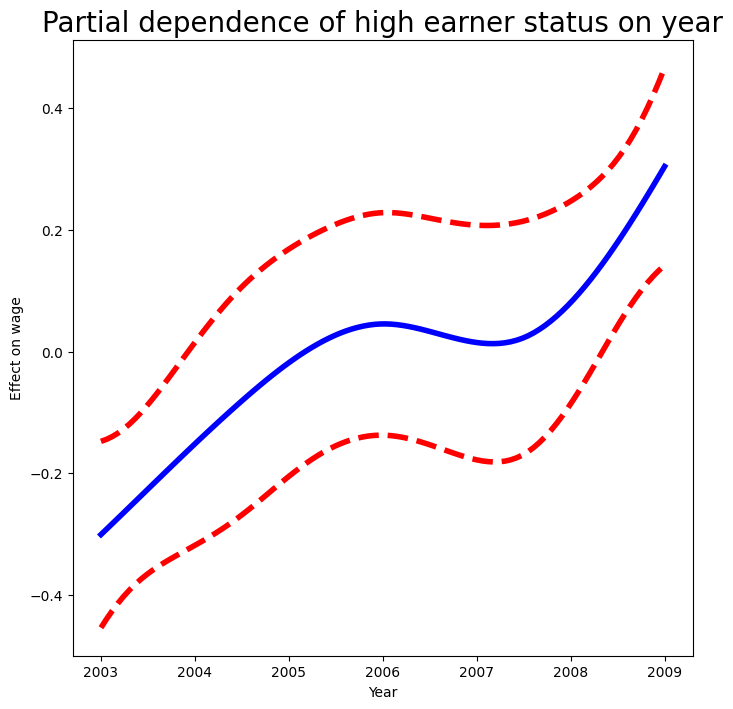

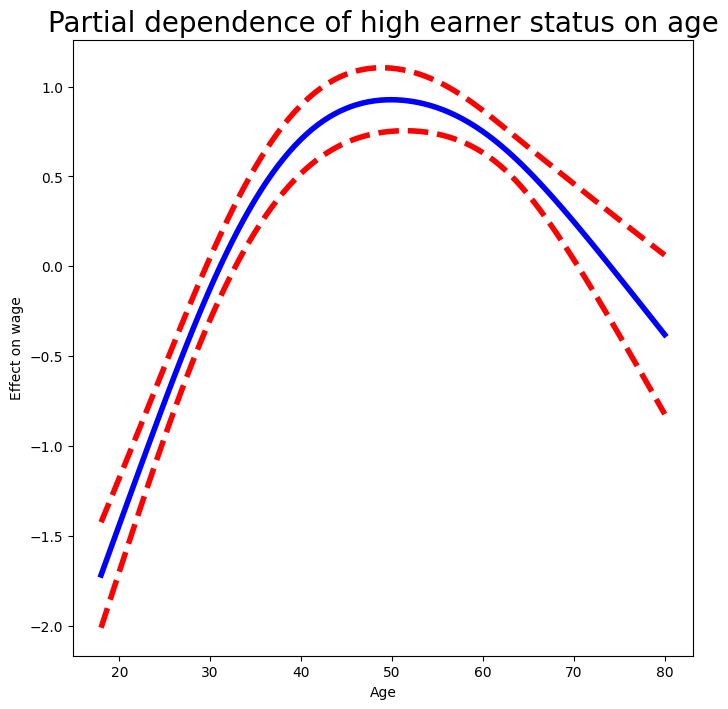

In [30]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_ , 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],fontsize=8);

fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_ , 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',fontsize=20);

fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_ , 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age',fontsize=20);

# QUESTION 10